In [1]:
%load_ext autoreload
%autoreload 2
from main  import *
import torch as t

In [2]:

class Config:
    caption_data_path='caption.pth'# 经过预处理后的人工描述信息
    img_path='/home/cy/caption_data/'
    # img_path='/mnt/ht/aichallenger/raw/ai_challenger_caption_train_20170902/caption_train_images_20170902/'
    img_feature_path = 'results.pth' # 所有图片的features,20w*2048的向量
    scale_size = 300
    img_size = 224 
    batch_size=8
    shuffle = True
    num_workers = 4
    rnn_hidden = 256
    embedding_dim = 256
    num_layers = 2
    share_embedding_weights=False

    prefix='checkpoints/caption'#模型保存前缀

    env = 'caption'
    plot_every = 10
    debug_file = '/tmp/debugc'

    model_ckpt = None # 模型断点保存路径
    lr=1e-3
    use_gpu=True
    epoch = 1

    #test_img = 'img/example1.jpg' 

In [3]:
opt = Config()    
opt.caption_data_path = 'caption.pth' # 原始数据
opt.test_img = 'img/13_image.png' # 输入图片
opt.use_gpu = False  # 是否使用GPU(没必要)
opt.model_ckpt='caption_0914_1947' # 预训练的模型

D:\Users\zero\Anaconda3\lib\site-packages\torchvision\transforms\transforms.py:256: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


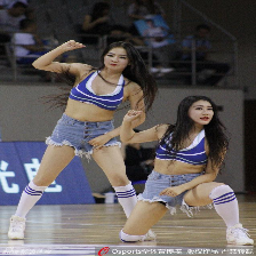

In [4]:
# 数据预处理
data = t.load(opt.caption_data_path)
word2ix,ix2word = data['word2ix'],data['ix2word']

IMAGENET_MEAN =  [0.485, 0.456, 0.406]
IMAGENET_STD =  [0.229, 0.224, 0.225]
normalize =  tv.transforms.Normalize(mean=IMAGENET_MEAN,std=IMAGENET_STD)
transforms = tv.transforms.Compose([
            tv.transforms.Scale(opt.scale_size),
            tv.transforms.CenterCrop(opt.img_size),
            tv.transforms.ToTensor(),
            normalize
    ])
img_ = Image.open(opt.test_img)
img = transforms(img_).unsqueeze(0)
img_.resize((int(img_.width*256/img_.height),256))

In [5]:
# 用resnet50来提取图片特征
# 如果本地没有预训练的模型文件，会自动下载
resnet50 = tv.models.resnet50(True).eval()
del resnet50.fc
resnet50.fc = lambda x:x
if opt.use_gpu:
    resnet50.cuda() 
    img = img.cuda()
img_feats = resnet50(Variable(img,volatile=True))

<ipython-input-5-70166c1e2c1c>:9: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img_feats = resnet50(Variable(img,volatile=True))


In [6]:
# Caption模型
import numpy as np
model = CaptionModel(opt,word2ix,ix2word)
model = model.load(opt.model_ckpt).eval()
if opt.use_gpu:
     model.cuda()
results = model.generate(img_feats.data[0])
print('\r\n'.join(results))

C:\Users\zero\Desktop\image_caption-main\model.py:59: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  img = t.autograd.Variable(img.unsqueeze(0), volatile=True)
C:\Users\zero\Desktop\image_caption-main\utils\beam_search.py:156: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  logprobs = log_softmax(output)
C:\Users\zero\Desktop\image_caption-main\utils\beam_search.py:180: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  input_feed = Variable(input_feed, volatile=True)


运动场 上 有 一群 穿着 短裤 的 女人 在 跳舞 </EOS>
运动场 上 有 三个 穿着 相同 衣服 的 女人 在 跳舞 </EOS>
运动场 上 有 三个 穿着 相同 衣服 的 女人 在 表演 </EOS>
